In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# This notebook will be for exploring win percentages for particular situations in NHL games since 2000,  including the post season since 2010.

We will first analyze wins for teams that score first, then see if this breakdown over year or over the time in the game the first goal occurs makes a large change.

After, we will do the same for 2 and 3 goal leads, then quickly look at the situation of 4+ goal leads.

In [3]:
data = pd.read_csv('goals.csv')

In [4]:
data.head()

,game_id,team_id_for,event,period,periodTime,goals_away,goals_home,won
0,2017020762,1,Goal,2,349,1,0,True
1,2017020762,1,Goal,3,331,2,0,True
2,2017020762,7,Goal,3,898,2,1,False
3,2017020762,1,Goal,3,1194,3,1,True
4,2015020565,8,Goal,1,74,1,0,True


In [5]:
data.shape

(180286, 8)

# Data Preparation and Exploration

In [6]:
# Show that all the event column is 'Goal', then drop it since it is redundant

data['event'].unique() # drop

array(['Goal'], dtype=object)

In [7]:
data = data.drop('event', axis=1)

We will have a use for a goals difference column since that is the main focus, so we will create that now.

In [8]:
data['goals_diff'] = np.absolute(data['goals_away'] - data['goals_home'])

The above shows the data we decided to keep. Notice that each row should be unique because the game_id will have a unique combination of goals_away and goals_home. We will check to see if there are any duplicates.

In [9]:
data[data.duplicated() == True]

,game_id,team_id_for,period,periodTime,goals_away,goals_home,won,goals_diff
16,2015020798,2,5,0,2,2,True,0
84,2016020883,8,5,0,2,2,True,0
91,2015020110,4,5,0,2,2,True,0
229,2016020510,17,5,0,3,3,True,0
236,2015020969,30,5,0,2,2,True,0
...,...,...,...,...,...,...,...,...
180281,2018020991,5,1,245,1,1,False,0
180282,2018020991,7,1,773,1,2,True,1
180283,2018020991,5,2,1038,2,2,False,0
180284,2018020991,5,2,1101,3,2,False,1


It appears there are many duplicate rows. Since all games should be uniquely identified by the game_id, goals_away, and goals_home combination, we will directly delete these.

In [10]:
data = data.drop_duplicates()

One thing to keep note of here: The sixth digit refers to the type of game: 1 = preseason, 2 = regular season, 3 = postseason, 4 = all star.

We would not be interested in either preseason or all star games, so let's delete those.

In [12]:
# Reset index for simplicity

data = data.reset_index()

data = data.drop('index', axis=1)

# Remove the rows with 6th entry in game_id as 1 or 4

idx_remove = []

for i in range(len(data)):
    char = str(data['game_id'][i])[5]
    if char == '1' or char == '4':
        idx_remove.append(i)
        
data = data.drop(idx_remove, axis=0)

Our data now only consists of regular season and playoff games, no duplicates. We now want to look for possible errors.
Let's plot when the goals were scored. Since there is no duplicates, we will break it down by period.

<AxesSubplot:xlabel='period', ylabel='count'>

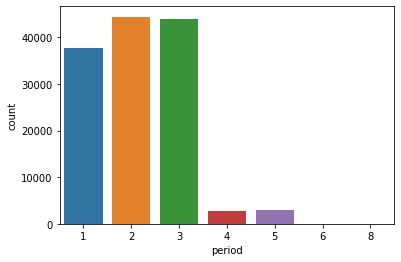

In [13]:
sns.countplot(data=data, x='period')

Since an NHL game is 3 periods, the 4th period represents OT. In the playoffs, OT can last indefinitely, which is why we can see the period go beyond 4. However, it is highly unlikely there should be more period 5 goals than 4 goals, so let's look at these.

In [14]:
per5_goals = data[data['period'] == 5]

per5_goals.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
game_id,2964.0,2.011349e+09,4.083021e+06,2.005020e+09,2.008020e+09,2.011021e+09,2.014021e+09,2.019030e+09
team_id_for,2964.0,1.675776e+01,1.089204e+01,1.000000e+00,8.000000e+00,1.600000e+01,2.400000e+01,5.400000e+01
period,2964.0,5.000000e+00,0.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
periodTime,2964.0,6.679825e+00,6.533239e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.600000e+02
goals_away,2964.0,2.392713e+00,1.131705e+00,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,6.000000e+00
goals_home,2964.0,2.391363e+00,1.132769e+00,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,6.000000e+00
goals_diff,2964.0,1.349528e-02,1.154021e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


The periodTime row is quite alarming because it is stating that over 75% of goals scored here scored zero seconds into the period. This is probably because the NHL API may count the 5th period as a shootout, which is untimed and has at least 5 opportunities for goals. We should remove all these rows with zero time.

Note that we have the record of who won and loss the game, so recording these goals will only give bad data at a loss of no information.

In [15]:
# Just make sure all the goal_diff = 0 for these

per5_goals[per5_goals['periodTime'] == 0]['goals_diff'].unique() # all zeros, which is not possible in OT after scoring.

array([0], dtype=int64)

In [16]:
data = data[(data['period'] !=5) | (data['periodTime'] != 0)] # Remove goals that were decided in period 5 and time 0

<AxesSubplot:xlabel='period', ylabel='count'>

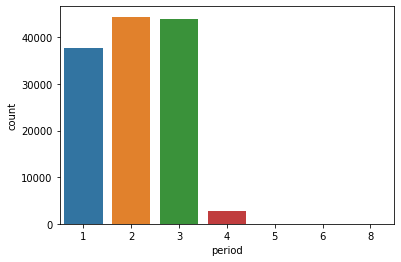

In [78]:
# Plot goals by period after fixing.

sns.countplot(data=data, x='period')

In [17]:
data['period'].value_counts() # See actual number of goals sorted by period.

2    44397
3    43820
1    37593
4     2773
5       40
6        6
8        1
Name: period, dtype: int64

The above shows what we would expect. There tends to be more goals scored in period 2 due to the "long change", but period 3 should have more goals than period 1 since team that are losing become more desparate to try to win. We will look and see if there are any other goals scored at periodTime=0 to make sure.

In [18]:
data[data['periodTime'] == 0]

,game_id,team_id_for,period,periodTime,goals_away,goals_home,won,goals_diff
29878,2013020971,29,1,0,1,0,True,1
97206,2005020312,18,1,0,1,0,True,1
121590,2019020876,24,1,0,0,1,False,1
121591,2019020876,19,1,0,1,1,True,0


In [19]:
# The above shows 4 potential errors, but with the goals_away and goals_home categories, it looks like
# the only error was in the periodTime column. We will look at these games individually to make sure

zero_time_game_ids = data[data['periodTime'] == 0]['game_id'].unique().tolist()

data.loc[data['game_id'].isin(zero_time_game_ids)]

,game_id,team_id_for,period,periodTime,goals_away,goals_home,won,goals_diff
29878,2013020971,29,1,0,1,0,True,1
29879,2013020971,29,1,93,2,0,True,2
29880,2013020971,29,1,807,3,0,True,3
29881,2013020971,25,3,519,3,1,False,2
97206,2005020312,18,1,0,1,0,True,1
97207,2005020312,18,1,236,2,0,True,2
97208,2005020312,17,2,40,2,1,False,1
97209,2005020312,17,2,315,2,2,False,0
97210,2005020312,18,2,570,3,2,True,1
121590,2019020876,24,1,0,0,1,False,1


The above shows all these seem to be timing errors from what we can tell because by the other columns everything seems to be okay.

In [20]:
# The last thing we will do is add a 'year' column since we would like to analyze the changes over time.

# The first four digits of the game_id column correspond to the year the season started.

# Since NHL rule changes do not occur mid year, any changes in rules will only be reflected on a year-by-year basis.

data['year'] = data['game_id'].apply(str).str.slice(stop=4).apply(int)

data.head()

,game_id,team_id_for,period,periodTime,goals_away,goals_home,won,goals_diff,year
0,2017020762,1,2,349,1,0,True,1,2017
1,2017020762,1,3,331,2,0,True,2,2017
2,2017020762,7,3,898,2,1,False,1,2017
3,2017020762,1,3,1194,3,1,True,2,2017
4,2015020565,8,1,74,1,0,True,1,2015


In [21]:
np.sort(data['year'].unique()) # Nothing strange. There was a lockout for the 2004 season, so thats why it's missing.

array([2000, 2001, 2002, 2003, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019], dtype=int64)

In [22]:
# Let's make sure there are no null values.

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128630 entries, 0 to 131617
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   game_id      128630 non-null  int64
 1   team_id_for  128630 non-null  int64
 2   period       128630 non-null  int64
 3   periodTime   128630 non-null  int64
 4   goals_away   128630 non-null  int64
 5   goals_home   128630 non-null  int64
 6   won          128630 non-null  bool 
 7   goals_diff   128630 non-null  int64
 8   year         128630 non-null  int64
dtypes: bool(1), int64(8)
memory usage: 9.0 MB


# Analyzing the First Goal Scored

In [23]:
# We will now look into winning vs scoring the first goal.

# Note: The easiest way to get this from the original dataframe is by the condition goals_away+goals_home = 1

first_goal = data[(data['goals_away'] + data['goals_home']) == 1]

first_goal.head() # Unless a game ended 0-0, this will include all game_ids.

,game_id,team_id_for,period,periodTime,goals_away,goals_home,won,goals_diff,year
0,2017020762,1,2,349,1,0,True,1,2017
4,2015020565,8,1,74,1,0,True,1,2015
10,2015020798,2,1,56,1,0,True,1,2015
16,2017021107,23,1,648,0,1,False,1,2017
24,2017021152,28,1,472,0,1,True,1,2017


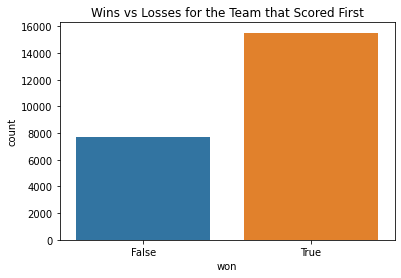

In [24]:
# We will first look at purely wins vs losses.

sns.countplot(data=first_goal, x='won')

plt.title('Wins vs Losses for the Team that Scored First')

plt.show()

In [25]:
# This is actually a much larger difference than I was expecting. Let's see the actual percentage.

perc_won = first_goal['won'].value_counts()[True] / len(first_goal) * 100

print('Percent of teams winning when scoring first: ' + str(round(perc_won, 3)) + '%')

Percent of teams winning when scoring first: 66.763%


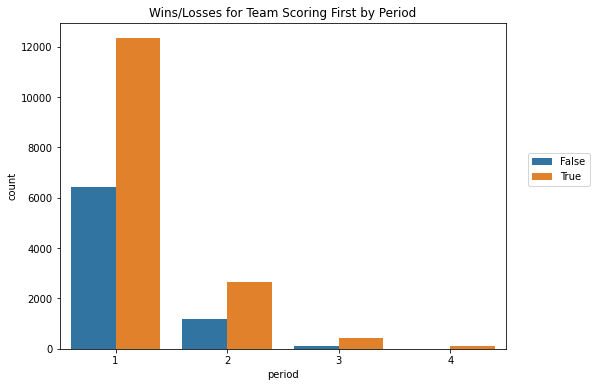

In [26]:
# As we can see, scoring the first goal wins at about a 2:1 ratio. The first goal is very important!

# We will now look at comparing this when the first goal occurs

plt.figure(figsize=(8,6))
sns.countplot(data=first_goal, x='period', hue='won')

plt.title('Wins/Losses for Team Scoring First by Period')
plt.legend(loc=(1.05, 0.5))
plt.show()

In [32]:
# Let's look at the percentages. Note that period 4+ would represent overtime, so scoring the first goal
# then would automatically result in a win, so we will not look at that period.

period_1 = (first_goal['period'] == 1)
period_2 = (first_goal['period'] == 2)
period_3 = (first_goal['period'] == 3)

won = (first_goal['won'] == True)

perc_per1 = len(first_goal[period_1 & won]) / len(first_goal[period_1]) * 100
perc_per2 = len(first_goal[period_2 & won]) / len(first_goal[period_2]) * 100
perc_per3 = len(first_goal[period_3 & won]) / len(first_goal[period_3]) * 100

print('Percent of winning with scoring first goal of game in period 1: ' + str(perc_per1))
print('Percent of winning with scoring first goal of game in period 2: ' + str(perc_per2))
print('Percent of winning with scoring first goal of game in period 3: ' + str(perc_per3))


Percent of winning with scoring first goal of game in period 1: 65.73650015976142
Percent of winning with scoring first goal of game in period 2: 69.27272727272728
Percent of winning with scoring first goal of game in period 3: 78.94736842105263


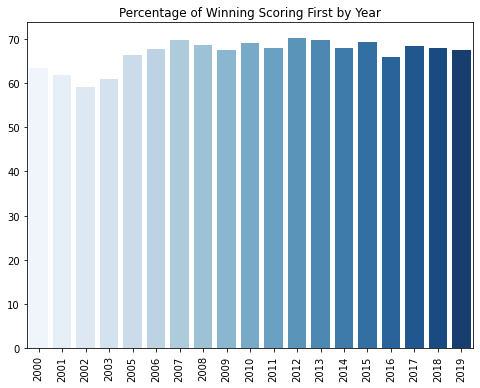

In [33]:
# We will look at the percentages won by year and visualize.

years = first_goal['year'].unique().tolist()
percentages = []

for year in years:
    year_cond = first_goal['year'] == year
    won_cond = first_goal['won'] == True
    
    denom = len(first_goal[year_cond])
    num = len(first_goal[year_cond & won_cond])
    
    perc = num / denom * 100
    
    percentages.append(perc)
    
    
plt.figure(figsize=(8,6))

sns.barplot(x=years, y=percentages, palette='Blues')

plt.xticks(rotation=90)
plt.title('Percentage of Winning Scoring First by Year')
plt.show()

We do see lower numbers  prior to the 2005 season. This is probably due to ties being recorded prior to this season, so a team that went up 1-0 could much more easily get tied and then the game ends. It has stayed relatively even since then

# Analyzing two goal leads

In [34]:
#We will now focus only on games that had a goal_diff of 2 at someone point, so
# games where the max(goal_diff) == 1 will not be considering.

two_goal_games = data[data['goals_diff'] == 2]
two_goal_games.head()

,game_id,team_id_for,period,periodTime,goals_away,goals_home,won,goals_diff,year
1,2017020762,1,3,331,2,0,True,2,2017
3,2017020762,1,3,1194,3,1,True,2,2017
5,2015020565,8,2,120,2,0,True,2,2015
7,2015020565,6,3,236,3,1,False,2,2015
19,2017021107,28,2,107,3,1,True,2,2017


Because we only want to count the win/loss for the team that achieved the two goal lead first, we need to sort by the period and periodTime. For simplicity, we will also sort by the game_id to make it easier to read.

In [35]:
two_goal_games = two_goal_games.sort_values(['game_id', 'period', 'periodTime'])

# It it is best to reset_index after sort, so everything is in order
two_goal_games = two_goal_games.reset_index()
two_goal_games = two_goal_games.drop('index', axis=1)
two_goal_games.head()

,game_id,team_id_for,period,periodTime,goals_away,goals_home,won,goals_diff,year
0,2000020001,25,1,1199,0,2,False,2,2000
1,2000020002,9,1,743,2,0,False,2,2000
2,2000020003,7,1,906,0,2,True,2,2000
3,2000020003,7,3,73,1,3,True,2,2000
4,2000020003,16,3,940,2,4,False,2,2000


Only want to keep the top one for each game_id. Find all unique game_id's here. Easiest way may be to make look at the series with 'game_id' column, drop the duplicates except the first, then record those indices and use them.

In [36]:
ids = two_goal_games['game_id'].drop_duplicates(keep='first') # get unique game_ids
indices = ids.index.tolist() # get their indices and put in list

final_two_goal_df = two_goal_games.iloc[indices] # create final two goal df 
final_two_goal_df.head()

,game_id,team_id_for,period,periodTime,goals_away,goals_home,won,goals_diff,year
0,2000020001,25,1,1199,0,2,False,2,2000
1,2000020002,9,1,743,2,0,False,2,2000
2,2000020003,7,1,906,0,2,True,2,2000
5,2000020004,4,3,1007,3,5,True,2,2000
6,2000020005,20,1,849,1,3,False,2,2000


The above df shows the games where at least a two goal lead was obtained, only showing the first instance it happened, the time it happened, and whether the team lost or won, without duplicates. We are now ready to analyze.

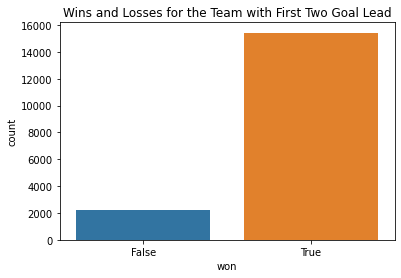

In [37]:
# We will first look purely at win vs loss.

sns.countplot(data=final_two_goal_df, x='won')

plt.title('Wins and Losses for the Team with First Two Goal Lead')

plt.show()

In [38]:
# We can there is a huge difference here. let's calculate the exact proportions

perc_won = len(final_two_goal_df[final_two_goal_df['won'] == True]) / len(final_two_goal_df) * 100

print('Percentage of teams with first two goal lead that won: ' + str(round(perc_won, 3)))

Percentage of teams with first two goal lead that won: 87.332


The above shows a very interesting outcome in that roughly 87% of teams that obtain the first two goal lead end up winning.

For the sake of interest, let's compare this to the time it happens in the game by period only.

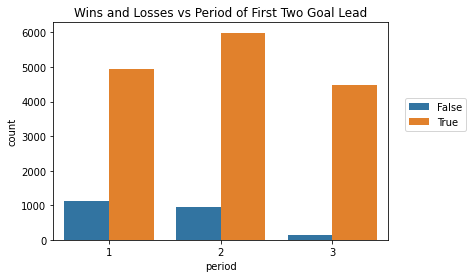

In [39]:
sns.countplot(data=final_two_goal_df, x='period', hue='won')

plt.title('Wins and Losses vs Period of First Two Goal Lead')

plt.legend(loc=(1.05,0.5))

plt.show()

As we would expect, the later this two goal lead occurs, chance of winning goes up. We can compute each of these exactly.

In [40]:
period_1 = final_two_goal_df['period'] == 1
period_2 = final_two_goal_df['period'] == 2
period_3 = final_two_goal_df['period'] == 3

won = final_two_goal_df['won'] == True

perc_per1 = len(final_two_goal_df[period_1 & won]) / len(final_two_goal_df[period_1]) * 100
perc_per2 = len(final_two_goal_df[period_2 & won]) / len(final_two_goal_df[period_2]) * 100
perc_per3 = len(final_two_goal_df[period_3 & won]) / len(final_two_goal_df[period_3]) * 100

print('Percent of winning with first two goal lead in period 1: ' + str(perc_per1))
print('Percent of winning with first two goal lead in period 2: ' + str(perc_per2))
print('Percent of winning with first two goal lead in period 3: ' + str(perc_per3))


Percent of winning with first two goal lead in period 1: 81.4845292955892
Percent of winning with first two goal lead in period 2: 86.19301021141953
Percent of winning with first two goal lead in period 3: 96.70045287901661


Obtaining the first two goal lead of the game in the third period, if it happens, is a very strong indication of winning a game, but we can see that overall, obtaining the first two goal lead shows a very large chance of winning.

Out of interest, we can break this down further by year to see if anything changes.

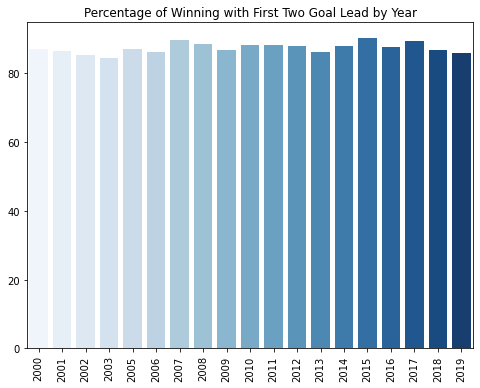

In [41]:
# It looks fairly consistent over time.

# There was a lock out for the 2004 season, so it never happened.

# For the 2012 season, it got a late start due to a hold out

# Let's find the percentages per year like above.
years = final_two_goal_df['year'].unique().tolist()
percentages = []

for year in years:
    year_cond = final_two_goal_df['year'] == year
    won_cond = final_two_goal_df['won'] == True
    
    denom = len(final_two_goal_df[year_cond])
    num = len(final_two_goal_df[year_cond & won_cond])
    
    perc = num / denom * 100
    
    percentages.append(perc)
    

plt.figure(figsize=(8,6))

sns.barplot(x=years, y=percentages, palette='Blues')

plt.xticks(rotation=90)
plt.title('Percentage of Winning with First Two Goal Lead by Year')
plt.show()

As we can see, over the years, pretty consistently the first team that takes a two goal lead wins between 80-90% of the games.

We also saw from a previous chart that the percentage goes up the later the two goal lead was take, by period, although the difference wasn't too drastic.

# Three Goal Lead Analysis

In [42]:
three_goal_games = data.loc[data['goals_diff'] == 3]

three_goal_games.head()

,game_id,team_id_for,period,periodTime,goals_away,goals_home,won,goals_diff,year
6,2015020565,8,2,1040,3,0,True,3,2015
8,2015020565,8,3,529,4,1,True,3,2015
28,2017021152,28,3,609,1,4,True,3,2017
39,2017020904,23,1,710,0,3,True,3,2017
48,2016020562,19,3,1126,1,4,True,3,2016


In [43]:
# Like above, there can be multiple instances of three goal leads, so we will get rid of duplicates.

# We will sort, reset the indices, then create our final df from the indices of the first instance
# from the sorted df.

three_goal_games = three_goal_games.sort_values(['game_id', 'period', 'periodTime'])

three_goal_games = three_goal_games.reset_index()
three_goal_games = three_goal_games.drop('index', axis=1)
three_goal_games.head()

,game_id,team_id_for,period,periodTime,goals_away,goals_home,won,goals_diff,year
0,2000020003,7,3,793,1,4,True,3,2000
1,2000020004,4,3,1185,3,6,True,3,2000
2,2000020006,27,2,949,1,4,True,3,2000
3,2000020007,1,2,299,2,5,True,3,2000
4,2000020007,1,3,237,3,6,True,3,2000


In [44]:
three_goal_games_ids = three_goal_games['game_id'].drop_duplicates(keep='first')

indices = three_goal_games_ids.index.tolist()

final_three_goals_df = three_goal_games.iloc[indices]

final_three_goals_df.head()

,game_id,team_id_for,period,periodTime,goals_away,goals_home,won,goals_diff,year
0,2000020003,7,3,793,1,4,True,3,2000
1,2000020004,4,3,1185,3,6,True,3,2000
2,2000020006,27,2,949,1,4,True,3,2000
3,2000020007,1,2,299,2,5,True,3,2000
6,2000020008,26,1,654,3,0,True,3,2000


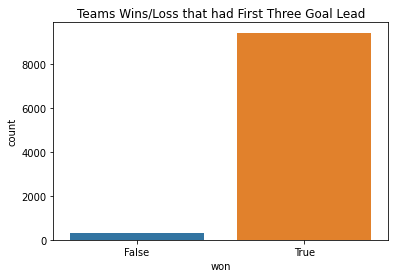

In [45]:
# Strictly compare wins vs losses for first term with =+3 goal diff

sns.countplot(data=final_three_goals_df, x='won')

plt.title('Teams Wins/Loss that had First Three Goal Lead')

plt.show()

In [46]:
# It looks like an even greater percentage, as expected since every team that had a 3 goal lead necessarily
# had a two goal lead. Find percentage of wins

perc_won = len(final_three_goals_df[final_three_goals_df['won'] == True]) / len(final_three_goals_df) * 100

print('Percentage of games won by team with first three goal lead: ' + str(round(perc_won, 3)))

Percentage of games won by team with first three goal lead: 96.616


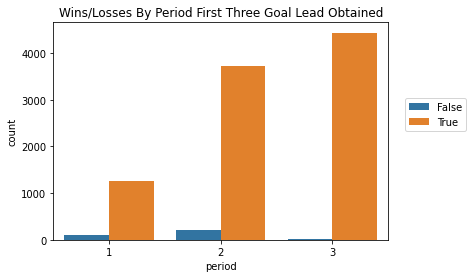

In [47]:
# Roughly 96.62% of teams with the first three goal lead end up winning. See if there is any
# difference by period

sns.countplot(data=final_three_goals_df, x='period', hue='won')

plt.title('Wins/Losses By Period First Three Goal Lead Obtained')

plt.legend(loc=(1.05, 0.5))
plt.show()

In [48]:
period_1 = final_three_goals_df['period'] == 1
period_2 = final_three_goals_df['period'] == 2
period_3 = final_three_goals_df['period'] == 3

won = final_three_goals_df['won'] == True

perc_per1 = len(final_three_goals_df[period_1 & won]) / len(final_three_goals_df[period_1]) * 100
perc_per2 = len(final_three_goals_df[period_2 & won]) / len(final_three_goals_df[period_2]) * 100
perc_per3 = len(final_three_goals_df[period_3 & won]) / len(final_three_goals_df[period_3]) * 100

print('Percent of winning with first three goal lead in period 1: ' + str(perc_per1))
print('Percent of winning with first three goal lead in period 2: ' + str(perc_per2))
print('Percent of winning with first three goal lead in period 3: ' + str(perc_per3))


Percent of winning with first three goal lead in period 1: 92.39209948792977
Percent of winning with first three goal lead in period 2: 94.90186082080041
Percent of winning with first three goal lead in period 3: 99.41717103788388


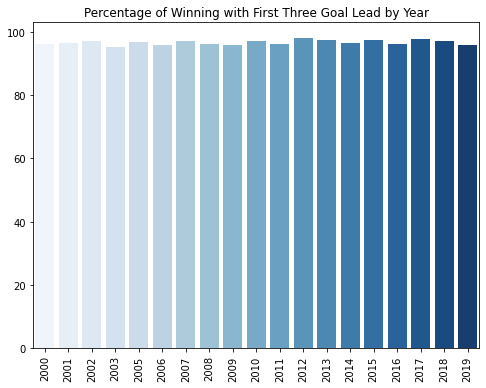

In [49]:
# Let's find the percentages won by year like above.

years = final_three_goals_df['year'].unique().tolist()
percentages = []

for year in years:
    year_cond = final_three_goals_df['year'] == year
    won_cond = final_three_goals_df['won'] == True
    
    denom = len(final_three_goals_df[year_cond])
    num = len(final_three_goals_df[year_cond & won_cond])
    
    perc = num / denom * 100
    
    percentages.append(perc)

    
plt.figure(figsize=(8,6))

sns.barplot(x=years, y=percentages, palette='Blues')

plt.xticks(rotation=90)
plt.title('Percentage of Winning with First Three Goal Lead by Year')
plt.show()

We have seen that, over the years, everything stays rather consistent. We could investigate the same idea with 4+ goal leads, but we will just quickly show that this is so rare for a team with 4+ goal lead to lose that it is not worth investigating further.

# Four Goal Lead Analysis

In [53]:
four_goal_games = data[data['goals_diff'] == 4]

four_goal_games = four_goal_games.sort_values(['game_id', 'period', 'periodTime'])

four_goal_games = four_goal_games.reset_index() # reset index after sorting
four_goal_games = four_goal_games.drop('index', axis=1)

indices = four_goal_games['game_id'].drop_duplicates().index.tolist()

four_goal_games_final = four_goal_games.iloc[indices]

four_goal_games_final['won'].value_counts()

True     3883
False      27
Name: won, dtype: int64

As we can see, only 27/3910 teams that got a four goal lead first ended up losing, so it is extremely rare. We will not investigate further.

A couple comments:

1) We noticed consistently that the percentages of winning went up the later a particular lead was first achieved by period. However, I do not think this would be an obvious result (aside from the third period when teams will pull their goalies to try to score, thus giving up more goals). 

The reason this pattern strikes me as surprising is, one could easily argue, the earlier a team gets to a particular lead, the better that team is than the other, so we could expect the earlier leads to win at a higher percentage.

The argument for the other side is that, the earlier a lead is obtained, the more time the other team has to come back, the greater the chance the team with the lead could lose. It is also common for teams to "take less chances" when they have a lead, and as a result, are less likely to score to try to protect the lead. Not scoring more does keep their risk for ultimately losing higher, so it is also possible the data suggests staying aggressive and doing what got a team the lead in the first place is what a team should continue to do.

By our data, it appears that the second would be a better explanation than the first, of course, there are many other variables.

2) Rules change over the years allowing it to be easier or harder to score. I was surprised to see such consistency with the data over the years. It would stand to reason, the easier it is to score, the more likely it is to give up a lead, but once again, nothing really suggests this happens since there are so many other variables at play. We can look at the average number of goals per year over the years to see if this is true, which we did in the "Goal Analysis" notebook. This showed the average number of goals per game stays between 2.5 - 3.0 pretty consistently, so not much difference here.

